In [3]:
#Imports
import os
import pandas as pd
import random
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc , precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
from datetime import datetime, timedelta

In [4]:
print(tf.config.list_physical_devices('GPU'))

[]


In [5]:
# Enable GPU acceleration
def configure_gpu():
    try:
        # List physical devices
        physical_devices = tf.config.list_physical_devices('GPU')
        
        if physical_devices:
            # Print available GPUs
            print(f"Found {len(physical_devices)} GPU(s):")
            for device in physical_devices:
                print(f" - {device}")
                
            # Important: Set memory growth BEFORE setting any other GPU configurations
            try:
                for device in physical_devices:
                    tf.config.experimental.set_memory_growth(device, True)
                print("Memory growth enabled on all GPUs")
            except RuntimeError as e:
                print(f"Warning: {e}")
                
            # Enable mixed precision after memory growth configuration
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            print("Enabled mixed precision training")
        else:
            print("No GPU devices found")
            
    except Exception as e:
        print(f"Error configuring GPU: {e}")


configure_gpu()


No GPU devices found


In [6]:
import torch
print(torch.cuda.is_available())

True


In [7]:
# Paths for the dataset, anotations, working directory and images
TRAIN_PATH = 'D:/Download/JDownloader/MSCOCO/images/train2017'
VAL_PATH = 'D:/Download/JDownloader/MSCOCO/images/val2017'
ANNOTATIONS_PATH = 'D:/Download/JDownloader/MSCOCO/annotations'
WORKING_DIR = 'D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/object_detection_model_compare/working'
VAL_MODEL_IMG = 'D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/object_detection_model_compare/val_model_img'
FILTERED_CATEGORIES = ['person', 'cat', 'dog']

In [8]:
# Load COCO annotations
annotations_file = os.path.join(ANNOTATIONS_PATH, 'instances_train2017.json')
coco = COCO(annotations_file)

# Get category IDs for the selected categories
category_ids = coco.getCatIds(catNms=FILTERED_CATEGORIES)

loading annotations into memory...
Done (t=9.78s)
creating index...
index created!


In [9]:
# # Get total image count per category
# category_image_counts = {}

# for category_name, category_id in zip(FILTERED_CATEGORIES, category_ids):
#     # Get all annotation IDs for the category
#     ann_ids = coco.getAnnIds(catIds=[category_id])
    
#     # Load annotations and extract unique image IDs
#     anns = coco.loadAnns(ann_ids)
#     image_ids = {ann['image_id'] for ann in anns}  # Use a set to ensure uniqueness
    
#     # Count unique images
#     category_image_counts[category_name] = len(image_ids)

# # Print results
# print("Total image count per category:")
# for category, count in category_image_counts.items():
#     print(f"{category}: {count}")

In [10]:
# # Generate filtered dataset to train the model

# # Collect up to 1000 annotations per category
# filtered_data = []
# for category_id in category_ids:
#     ann_ids = coco.getAnnIds(catIds=[category_id])
#     anns = coco.loadAnns(ann_ids)
#     selected_anns = random.sample(anns, min(1000, len(anns)))
#     for ann in selected_anns:
#         image_info = coco.loadImgs(ann['image_id'])[0]
#         filtered_data.append({
#             "image_id": ann['image_id'],
#             "image": image_info['file_name'],
#             "category_id": ann['category_id']
#         })

# # Save filtered data to CSV
# filtered_csv_path = os.path.join(WORKING_DIR, 'filtered_coco.csv')
# filtered_df = pd.DataFrame(filtered_data)
# filtered_df.to_csv(filtered_csv_path, index=False)

# print(f"Filtered dataset saved to {os.path.abspath(filtered_csv_path)}")

In [11]:
# # Split the filtered dataset
# # Load the filtered CSV
# data = pd.read_csv(filtered_csv_path)

# # Display record count per category_id
# category_counts = data['category_id'].value_counts()
# print("Record count per category_id:")
# print(category_counts)
# print("")

# # Split into training and testing datasets
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# # Display record count per category_id train and test
# category_train_counts = train_data['category_id'].value_counts()
# print("Train - Record count per category_id:")
# print(category_train_counts)
# print("")

# category_test_counts = test_data['category_id'].value_counts()
# print("Test - Record count per category_id:")
# print(category_test_counts)
# print("")

# # Save the split datasets
# train_csv_path = os.path.join(WORKING_DIR, 'train_data.csv')
# test_csv_path = os.path.join(WORKING_DIR, 'test_data.csv')

# train_data.to_csv(train_csv_path, index=False)
# test_data.to_csv(test_csv_path, index=False)

# print(f"Training dataset saved to {os.path.abspath(train_csv_path)}")
# print(f"Testing dataset saved to {os.path.abspath(test_csv_path)}")



In [12]:
# Load split datasets
train_csv_path = os.path.join(WORKING_DIR, 'train_data.csv')
test_csv_path = os.path.join(WORKING_DIR, 'test_data.csv')

train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)

In [13]:
# Preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess an image for MobileNetV2."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Load images and labels
def load_data(data, path_prefix, target_size=(224, 224)):
    images = []
    labels = []
    for _, row in data.iterrows():
        image_path = os.path.join(path_prefix, row['image'])
        images.append(preprocess_image(image_path, target_size))
        labels.append(row['category_id'])
    return np.array(images), np.array(labels)

X_train, y_train = load_data(train_data, TRAIN_PATH)
X_test, y_test = load_data(test_data, TRAIN_PATH)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train))
y_test_encoded = to_categorical(label_encoder.transform(y_test))


In [14]:
# Build the model using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some of the later layers for fine-tuning
for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True

# Add improved classification head
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)  # Use GAP instead of Flatten
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)
model = Model(inputs, outputs)

# Compile with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

# Get current datetime and format it
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Define file path for the model summary
model_summary_path = os.path.join(WORKING_DIR, f'model_summary_{timestamp}.png')

# Save the model summary as an image
plot_model(model, to_file=model_summary_path, show_shapes=True, show_layer_names=True)

print(f"Model summary saved as an image at {model_summary_path}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,619,203 (9.99 MB)

 Trainable params: 2,585,091 (9.86 MB)

 Non-trainable params: 34,112 (133.25 KB)

Model summary saved as an image at D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/object_detection_model_compare/working\model_summary_20241224_185453.png


In [15]:
# Get current timestamp for file naming
timestamp = time.strftime('%Y%m%d_%H%M%S')

# Record start time
start_time = time.time()

# Add callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
]

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training
history = model.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=32),
    validation_data=(X_test, y_test_encoded),
    epochs=30,  # Increase epochs since we have early stopping
   # callbacks=callbacks,
    verbose=1
)

# Calculate training time
end_time = time.time()
training_time = end_time - start_time
training_duration = str(timedelta(seconds=training_time))

# Print training time
print("\nModel Training Time:")
print(f"Total seconds: {training_time:.2f} seconds")
print(f"Formatted duration: {training_duration}")
print(f"Average time per epoch: {(training_time/len(history.history['loss'])):.2f} seconds")

# Create log filename with timestamp
log_filename = f'training_log_{timestamp}.txt'
log_filepath = os.path.join(WORKING_DIR, log_filename)

# Save detailed training log
with open(log_filepath, 'w') as f:
    f.write(f"Training Log - {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("="*50 + "\n\n")
    
    f.write("Training Time Details:\n")
    f.write("-"*20 + "\n")
    f.write(f"Start Time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(start_time))}\n")
    f.write(f"End Time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(end_time))}\n")
    f.write(f"Total Training Time: {training_duration}\n")
    f.write(f"Total Seconds: {training_time:.2f}\n")
    f.write(f"Average Time per Epoch: {(training_time/len(history.history['loss'])):.2f} seconds\n\n")
    
    f.write("Training Parameters:\n")
    f.write("-"*20 + "\n")
    f.write(f"Number of Epochs: {len(history.history['loss'])}\n")
    f.write(f"Batch Size: 32\n")
    f.write(f"Training Samples: {len(X_train)}\n")
    f.write(f"Validation Samples: {len(X_test)}\n\n")
    
    f.write("Final Model Performance:\n")
    f.write("-"*20 + "\n")
    f.write(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}\n")
    f.write(f"Final Training Loss: {history.history['loss'][-1]:.4f}\n")
    f.write(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}\n")
    f.write(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}\n")

print(f"\nTraining log saved to: {log_filepath}")

# # Train the model
# history = model.fit(
#     X_train, y_train_encoded,
#     validation_data=(X_test, y_test_encoded),
#     epochs=30,  # Adjust epochs based on performance
#     batch_size=32,
#     verbose=1
# )

C:\Users\lauro\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.4699 - loss: 6.9633 - val_accuracy: 0.7550 - val_loss: 6.2293
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7223 - loss: 6.1745 - val_accuracy: 0.7700 - val_loss: 5.9036
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7938 - loss: 5.6727 - val_accuracy: 0.7917 - val_loss: 5.5504
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8209 - loss: 5.2647 - val_accuracy: 0.7817 - val_loss: 5.1881
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8474 - loss: 4.8781 - val_accuracy: 0.8017 - val_loss: 4.8643
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8497 - loss: 4.5065 - val_accuracy: 0.8133 - val_loss: 4.5159
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8994 - loss: 4.1107 - val_accuracy: 0.7733 - val_loss: 4.2940
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9021 - loss: 3.7921 - val_accuracy: 0.7650 - val_loss

In [16]:
# Save the trained model
model_path = os.path.join(WORKING_DIR, 'mobilenet_v2_coco.keras')
model.save(model_path)

print(f"Trained model saved at {model_path}")

Trained model saved at D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/object_detection_model_compare/working\mobilenet_v2_coco.keras


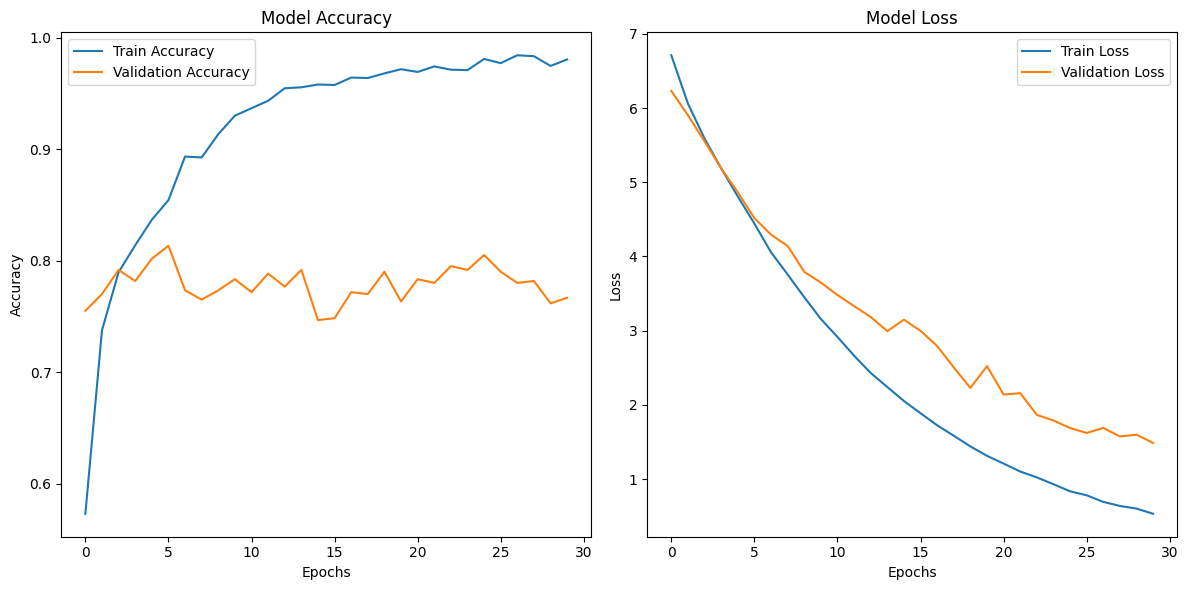

Accuracy and loss plot saved at D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/object_detection_model_compare/working\accuracy_loss_plot_20241224_193837.png
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step


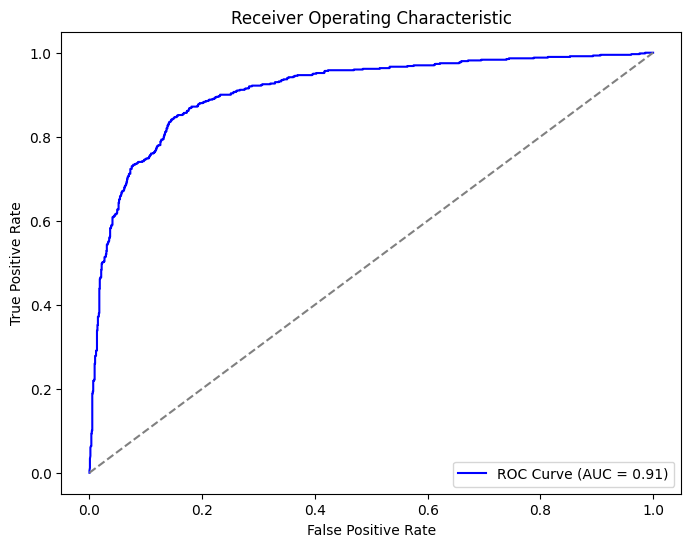

ROC Curve plot saved at D:/Projetos/Mestrado/2024_Topicos_Esp_Sist_Informacao/ARTIGO_FINAL/object_detection_model_compare/working\roc_curve_plot_20241224_193837.png


In [17]:
# Get current datetime and format it
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Define file paths with timestamp
accuracy_loss_plot_path = os.path.join(WORKING_DIR, f'accuracy_loss_plot_{timestamp}.png')
roc_curve_plot_path = os.path.join(WORKING_DIR, f'roc_curve_plot_{timestamp}.png')

# Plot training accuracy and loss
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
# Save accuracy and loss plot with timestamp
plt.savefig(accuracy_loss_plot_path, dpi=300)  # Save with high resolution
plt.show()

print(f"Accuracy and loss plot saved at {accuracy_loss_plot_path}")

# ROC Curve
y_test_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test_encoded.ravel(), y_test_pred.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Save ROC curve plot with timestamp
plt.savefig(roc_curve_plot_path, dpi=300)  # Save with high resolution
plt.show()

print(f"ROC Curve plot saved at {roc_curve_plot_path}")

In [18]:
# Evaluate the model precision-recall , average precision and mAP
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test_encoded, axis=1)

# Calculate precision-recall and average precision for each class


# Number of classes
num_classes = y_test_encoded.shape[1]

# Store AP values for each class
average_precisions = {}

# Plot Precision-Recall curves
plt.figure(figsize=(10, 7))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_encoded[:, i], y_pred[:, i])
    ap = average_precision_score(y_test_encoded[:, i], y_pred[:, i])
    average_precisions[i] = ap

    # Plot PR curve for each class
    plt.plot(recall, precision, label=f"Class {label_encoder.classes_[i]} (AP={ap:.2f})")

# Calculate mAP
mAP = np.mean(list(average_precisions.values()))
print(f"Mean Average Precision (mAP): {mAP:.4f}")

# Finalize PR plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Save the PR curve plot
pr_curve_path = os.path.join(WORKING_DIR, f'pr_curve_{timestamp}.png')
plt.savefig(pr_curve_path)
plt.show()
print(f"Precision-Recall curve saved at {pr_curve_path}")

# Compare with another model (example usage)
# Assuming you have predictions from another model in `y_pred_other`
# y_pred_other = ...

# Uncomment the below lines to compare:
# average_precisions_other = {}
# for i in range(num_classes):
#     precision, recall, _ = precision_recall_curve(y_test_encoded[:, i], y_pred_other[:, i])
#     ap = average_precision_score(y_test_encoded[:, i], y_pred_other[:, i])
#     average_precisions_other[i] = ap
#
# mAP_other = np.mean(list(average_precisions_other.values()))
# print(f"Comparison Model mAP: {mAP_other:.4f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 202ms/step


NameError: name 'precision_recall_curve' is not defined

<Figure size 1000x700 with 0 Axes>

In [ ]:
# Load the saved model
model_path = os.path.join(WORKING_DIR, 'mobilenet_v2_coco.keras')
loaded_model = tf.keras.models.load_model(model_path)
print(f"Model loaded from {model_path}")

In [ ]:
# Load COCO validation annotations
val_annotations_file = os.path.join(ANNOTATIONS_PATH, 'instances_val2017.json')
coco_val = COCO(val_annotations_file)

In [17]:
# Function to predict category for an image, now measuring inference time
def predict_category_with_time(image_path, model, target_size=(224, 224)):
    image = preprocess_image(image_path, target_size)
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Measure inference time
    start_time = time.time()
    predictions = model.predict(image)
    inference_time = time.time() - start_time

    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]
    return predicted_class, confidence, inference_time

# Function to display image with prediction results and inference time
def display_image_with_prediction(image_path, predicted_label, confidence, inference_time):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for display
    true_category = coco_val.cats[predicted_label]['name']  
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {true_category}\n"
              f"Predicted: {predicted_label} ({confidence*100:.2f}%)\n"
              f"Inference Time: {inference_time*1000:.2f} ms")
    plt.show()

In [ ]:
# Validate the model with a few images
image_filenames = ['000000205834.jpg', '000000050811.jpg', '000000058111.jpg']

# Create full paths for the images
validation_images = {filename: os.path.join(VAL_MODEL_IMG, filename) for filename in image_filenames}

# Perform predictions and display images with inference time
for filename, image_path in validation_images.items():
    predicted_class, confidence, inference_time = predict_category_with_time(image_path, loaded_model)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    # Display image with prediction results and inference time
    display_image_with_prediction(image_path, predicted_label, confidence, inference_time)


In [ ]:
#Generate Validation Dataset to infer medium acuracy and time 

# Collect up to 280 annotations per category
val_filtered_data = []
for category_id in category_ids:
    ann_ids = coco_val.getAnnIds(catIds=[category_id])
    anns = coco_val.loadAnns(ann_ids)
    selected_anns = random.sample(anns, min(280, len(anns)))
    for ann in selected_anns:
        image_info = coco_val.loadImgs(ann['image_id'])[0]
        val_filtered_data.append({
            "image_id": ann['image_id'],
            "image": image_info['file_name'],
            "category_id": ann['category_id']
        })

# Save filtered data to CSV
val_filtered_csv_path = os.path.join(WORKING_DIR, 'val_filtered_data.csv')
val_filtered_df = pd.DataFrame(val_filtered_data)
val_filtered_df.to_csv(val_filtered_csv_path, index=False)

print(f"Validation Filtered dataset saved to {os.path.abspath(val_filtered_csv_path)}")


# Load the filtered CSV
val_data = pd.read_csv(val_filtered_csv_path)

# Display record count per category_id to validate
val_category_counts = val_data['category_id'].value_counts()
print("Record count per category_id:")
print(val_category_counts)
print("")

In [ ]:
# Add new columns to val_data
val_data['predicted_class'] = None
val_data['confidence'] = None
val_data['inference_time'] = None

# Process each record in val_data
for index, row in val_data.iterrows():
    image_path = os.path.join(VAL_PATH, row['image'])  # Construct full image path    
    predicted_class, confidence, inference_time = predict_category_with_time(image_path, loaded_model)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    # Save results to val_data
    val_data.at[index, 'predicted_class'] = predicted_label
    val_data.at[index, 'confidence'] = round(confidence * 100, 2)
    val_data.at[index, 'inference_time'] = inference_time

In [ ]:
# Save filtered data to CSV
val_data_inference_csv_path = os.path.join(WORKING_DIR, 'val_data_inference.csv')
val_data_inference = pd.DataFrame(val_data)
val_data_inference.to_csv(val_data_inference_csv_path, index=False)

print(f"Validation Filtered dataset saved to {os.path.abspath(val_data_inference_csv_path)}")    

In [ ]:
# Calculate and display averages
average_confidence = val_data['confidence'].mean()
average_inference_time = val_data['inference_time'].mean()

print(f"Average Confidence: {average_confidence:.2f}%")
print(f"Average Inference Time: {average_inference_time*1000:.2f} ms")
print("")
print(f"Total Validation Records: {val_data.shape[0]}")
print("")

# Identify mismatches
mismatched_records = val_data[val_data['predicted_class'] != val_data['category_id']]
print(f"Records where predicted_class differs from category_id: {mismatched_records.shape[0]}")
print("")

# Identify equals
equals_records = val_data[val_data['predicted_class'] == val_data['category_id']]
equals_count = equals_records.shape[0]
print(f"Records where predicted_class equals category_id: {equals_count}")
print("")

# Calculate percentage of matches
total_records = val_data.shape[0]
percentage_equals = (equals_count / total_records) * 100
print(f"Percentage of records where predicted_class equals category_id: {percentage_equals:.2f}%")
